### Summarising Calibration results

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pyabc
from network_input_builder import *
path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"


In [66]:

sns.set_style("whitegrid")

which_params = "full_omn"

# list of model identifiers (your db_path values)
models = [
    "nonbehav",
    "otj_nonbehav",
    "otj_disc",
    "otj_disc_no_rw",
   "otj_cyclical_e_disc",
    "otj_cyclical_e_disc_no_rw",
]

# human-readable mapping
name_map = {
    "nonbehav": "Non-behavioural",
    "otj_nonbehav": "Non-behavioural w. OTJ",
    "otj_cyclical_e_disc": "Behavioural w. Cyc. OTJ w. RW",
    "otj_disc": "Behavioural w.o. Cyc. OTJ w. RW",
    "otj_cyclical_e_disc_no_rw": "Behavioural w. Cyc. OTJ w.o RW",
    "otj_disc_no_rw": "Behavioural w.o. Cyc. OTJ w.o RW",
}


In [67]:
# replace this function with your actual loader that returns (df, w)
def load_model_distribution(db_path):
    """
    Return (df, w) for a model. Replace this with your code that
    reads history and calls history.get_distribution(t=history.max_t).
    df: pandas.DataFrame with columns 'd_u', 'gamma_u', optional 'theta'
    w: 1D numpy array of weights aligned with df.index
    """
    # --- PLACEHOLDER: replace with your actual loader ---
    history = pyabc.History("sqlite:///" + f"output/{which_params}/{name}.db")
    print(f"output/{which_params}/{name}.db")
    df, w = history.get_distribution(t=history.max_t)

    return df, w

# safe kde wrapper: uses seaborn weights when available, else resamples
def plot_kde_on_ax(ax, x, y=None, weights=None, label=None, color=None, bw_adjust=1.0, fill=False, levels=6):
    """
    If y is None -> 1d kde; if y provided -> 2d kde contour.
    Tries to use sns.kdeplot(weights=...). If seaborn does not support weights for your version,
    falls back to weighted resampling.
    """
    use_seaborn_weights = True
    try:
        # try a direct call - will raise if weights unsupported
        if y is None:
            sns.kdeplot(x=x, ax=ax, weights=weights, label=label, color=color, bw_adjust=bw_adjust, fill=fill)
        else:
            sns.kdeplot(x=x, y=y, ax=ax, weights=weights, color=color, levels=levels, bw_adjust=bw_adjust, fill=fill)
        return
    except TypeError:
        use_seaborn_weights = False

    # fallback: weighted resample
    n_resample = min(4000, max(500, int(len(x) * 0.1)))  # sample up to 4000 points
    if weights is None:
        idx = np.random.choice(len(x), size=n_resample, replace=True)
    else:
        p = np.array(weights, dtype=float)
        p = p / p.sum()
        idx = np.random.choice(len(x), size=n_resample, replace=True, p=p)

    xs = np.asarray(x)[idx]
    if y is None:
        sns.kdeplot(x=xs, ax=ax, label=label, color=color, bw_adjust=bw_adjust, fill=fill)
    else:
        ys = np.asarray(y)[idx]
        sns.kdeplot(x=xs, y=ys, ax=ax, label=label, color=color, levels=levels, bw_adjust=bw_adjust, fill=fill)


# Collect all model samples
samples = {}
for name in models:
    try:
        df, w = load_model_distribution(name)
    except NotImplementedError:
        # ####### TEMP TEST DATA (remove when you plug in real loader) #######
        # Create a toy df to let the script run for demo purposes.
        rng = np.random.RandomState(abs(hash(name)) % 2**32)
        n = 2000
        # d_u and gamma_u vary by model label
        base = {"nonbehav": 0.2, "otj_nonbehav": 0.25, "otj_disc": 0.3,
                "otj_disc_no_rw": 0.28, "otj_cyclical_e_disc": 0.45, "otj_cyclical_e_disc_no_rw": 0.42}
        theta_present = name in ("otj_cyclical_e_disc", "otj_cyclical_e_disc_no_rw")
        df = pd.DataFrame({
            "d_u": rng.normal(loc=base[name], scale=0.03, size=n),
            "gamma_u": rng.normal(loc=base[name]*1.5, scale=0.05, size=n),
        })
        if theta_present:
            df["theta"] = rng.normal(loc=0.35, scale=0.06, size=n)
        w = np.ones(len(df)) / len(df)
        # ###################################################################
    samples[name] = {"df": df, "w": np.asarray(w)}

# palette & colors
palette = sns.color_palette("tab10", n_colors=len(models))
colors = dict(zip(models, palette))

# compute global axis limits for nicer consistent plotting
def global_limits(col, pad_frac=0.05):
    vals = []
    for m in samples:
        ser = samples[m]["df"].get(col)
        if ser is None: continue
        vals.append(ser.values)
    if len(vals) == 0:
        return None
    arr = np.concatenate(vals)
    lo, hi = np.nanpercentile(arr, [0.5, 99.5])
    rng = hi - lo
    return (max(0, lo - pad_frac*rng), hi + pad_frac*rng)

du_lim = global_limits("d_u")
gu_lim = global_limits("gamma_u")
theta_lim = global_limits("theta")

out_dir = f'output/{which_params}/combined_plots'
os.makedirs(out_dir, exist_ok=True)



output/full_omn/nonbehav.db
output/full_omn/otj_nonbehav.db
output/full_omn/otj_disc.db
output/full_omn/otj_disc_no_rw.db
output/full_omn/otj_cyclical_e_disc.db
output/full_omn/otj_cyclical_e_disc_no_rw.db


{'nonbehav': {'df': name       d_u   gamma_u
id                      
1353  0.136680  0.843687
1354  0.139230  0.796014
1355  0.136422  0.882997
1356  0.132743  0.894092
1357  0.137023  0.886819
1358  0.136927  0.865151
1359  0.134864  0.833254
1360  0.138328  0.869564
1361  0.137488  0.800668
1362  0.135352  0.887897
1363  0.139346  0.842775
1364  0.138404  0.848726
1365  0.140131  0.793364
1366  0.140004  0.875534
1367  0.137803  0.836892
1368  0.139456  0.768377
1369  0.132212  0.889175
1370  0.139140  0.734903
1371  0.135899  0.867797
1372  0.136768  0.803720
1373  0.134324  0.899043
1374  0.135036  0.861846
1375  0.135557  0.862219
1376  0.139236  0.807565
1377  0.138438  0.864142
1378  0.138667  0.740030
1379  0.131790  0.884853
1380  0.135100  0.879705
1381  0.137783  0.806457
1382  0.136318  0.885392
1383  0.141342  0.809363
1384  0.135226  0.855774
1385  0.138469  0.889557
1386  0.141089  0.844090
1387  0.137755  0.889872
1388  0.135598  0.895464
1389  0.138727  0.799095
1390 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

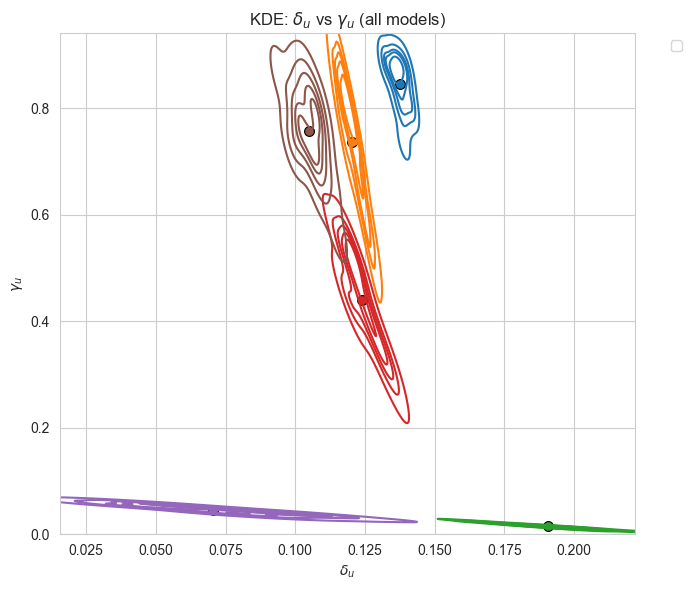

In [68]:
print(samples)
# ------------------- 1) Joint: d_u vs gamma_u (all models) -------------------
fig, ax = plt.subplots(figsize=(7,6))
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    if "d_u" not in df.columns or "gamma_u" not in df.columns:
        continue
    plot_kde_on_ax(ax, df["d_u"], df["gamma_u"], weights=w, label=name_map.get(name, name), color=colors[name], levels=6)
    # weighted mean marker
    mx = np.average(df["d_u"].values, weights=w)
    my = np.average(df["gamma_u"].values, weights=w)
    ax.scatter(mx, my, color=colors[name], s=50, marker="o", edgecolor="k", linewidth=0.8)

ax.set_xlabel(r"$\delta_u$")
ax.set_ylabel(r"$\gamma_u$")
if du_lim: ax.set_xlim(du_lim)
if gu_lim: ax.set_ylim(gu_lim)
ax.set_title(r"KDE: $\delta_u$ vs $\gamma_u$ (all models)")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "all_models_du_vs_gu.png"), dpi=300)
plt.show()
plt.close(fig)




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

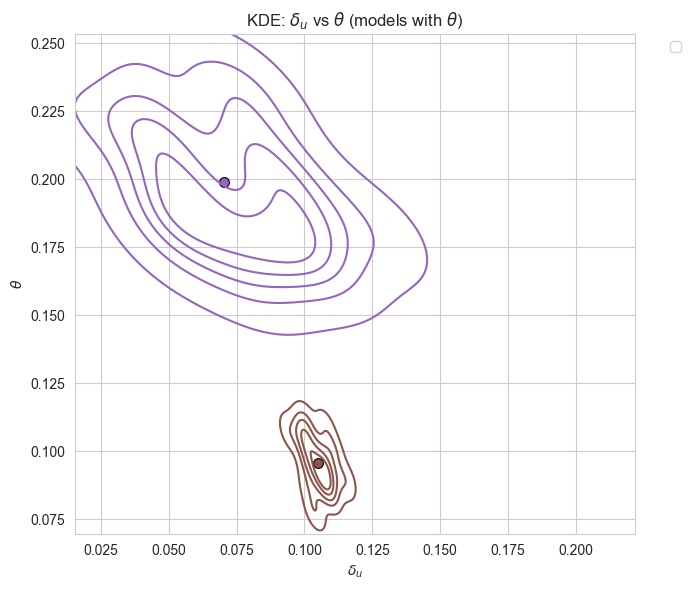

In [70]:
# ------------------- 2) Joint: d_u vs theta (only models with theta) -------------------
fig, ax = plt.subplots(figsize=(7,6))
any_theta = False
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    if "theta" not in df.columns:
        continue
    any_theta = True
    plot_kde_on_ax(ax, df["d_u"], df["theta"], weights=w, label=name_map.get(name, name), color=colors[name], levels=6)
    ax.scatter(np.average(df["d_u"].values, weights=w), np.average(df["theta"].values, weights=w),
               color=colors[name], s=50, marker="o", edgecolor="k", linewidth=0.8)

if any_theta:
    ax.set_xlabel(r"$\delta_u$")
    ax.set_ylabel(r"$\theta$")
    if du_lim: ax.set_xlim(du_lim)
    if theta_lim: ax.set_ylim(theta_lim)
    ax.set_title(r"KDE: $\delta_u$ vs $\theta$ (models with $\theta$)")
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "all_models_du_vs_theta.png"), dpi=300)
    plt.show()
    plt.close(fig)
else:
    print("No models had theta -> skipping d_u vs theta plot.")



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

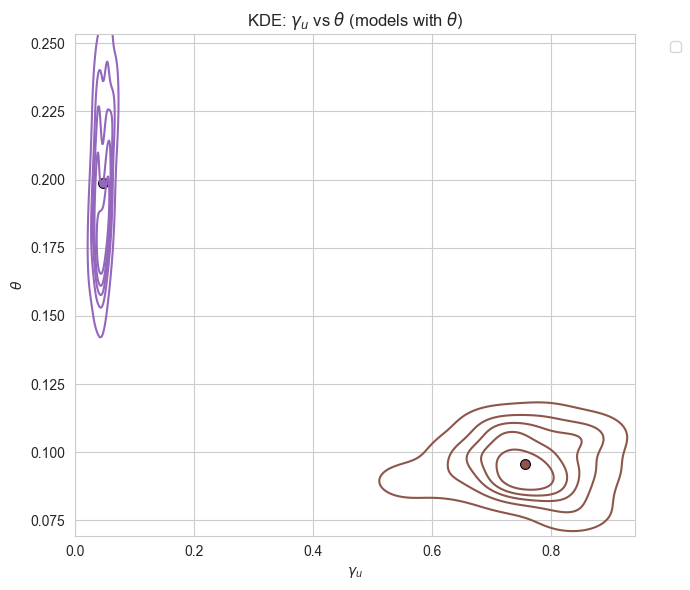

<Figure size 640x480 with 0 Axes>

In [71]:

# ------------------- 3) Joint: gamma_u vs theta (only models with theta) -------------------
fig, ax = plt.subplots(figsize=(7,6))
any_theta = False
for name, meta in samples.items():
    df = meta["df"]
    w = meta["w"]
    if "theta" not in df.columns:
        continue
    any_theta = True
    plot_kde_on_ax(ax, df["gamma_u"], df["theta"], weights=w, label=name_map.get(name, name), color=colors[name], levels=6)
    ax.scatter(np.average(df["gamma_u"].values, weights=w), np.average(df["theta"].values, weights=w),
               color=colors[name], s=50, marker="o", edgecolor="k", linewidth=0.8)

if any_theta:
    ax.set_xlabel(r"$\gamma_u$")
    ax.set_ylabel(r"$\theta$")
    if gu_lim: ax.set_xlim(gu_lim)
    if theta_lim: ax.set_ylim(theta_lim)
    ax.set_title(r"KDE: $\gamma_u$ vs $\theta$ (models with $\theta$)")
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(out_dir, "all_models_gu_vs_theta.png"), dpi=300)
    plt.close(fig)
else:
    print("No models had theta -> skipping gamma_u vs theta plot.")




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

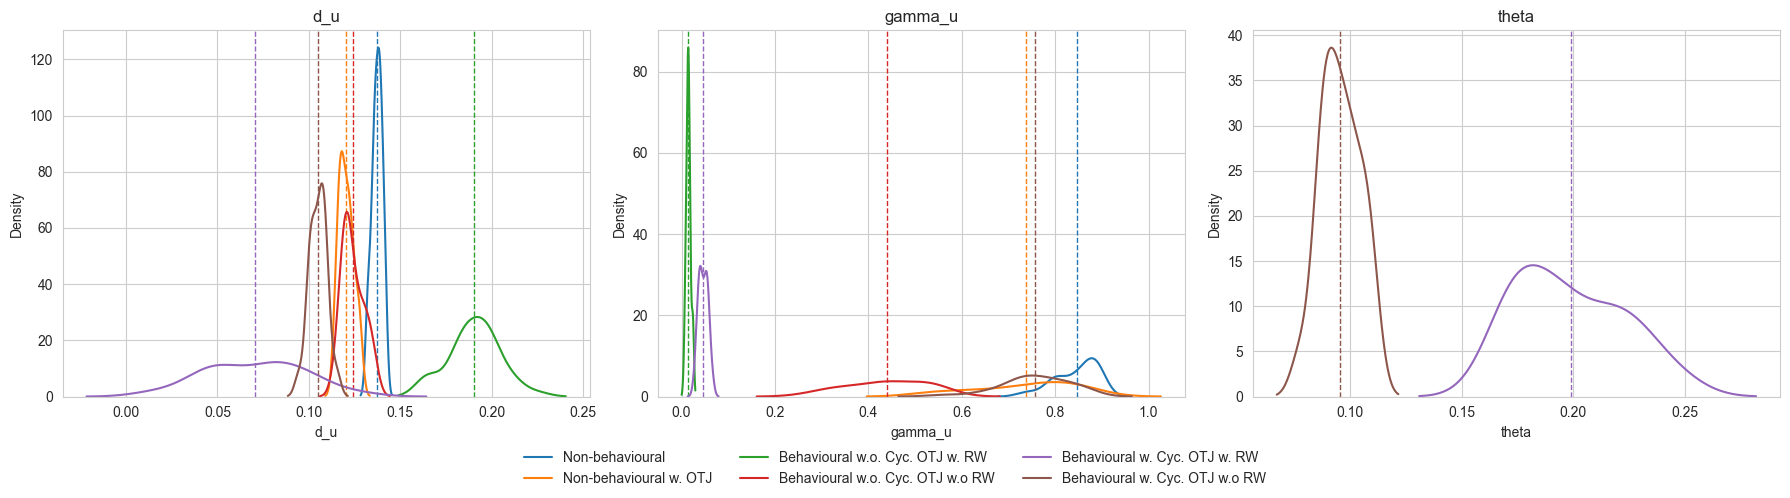

Saved combined plots to output/full_omn/combined_plots


In [73]:
# ------------------- 4) "Diagonal KDE matrix": 1D marginals overlaid -------------------
vars_to_plot = ["d_u", "gamma_u", "theta"]
fig, axes = plt.subplots(1, 3, figsize=(18,5))   # wider subplots

for idx, var in enumerate(vars_to_plot):
    ax = axes[idx]
    for name, meta in samples.items():
        df = meta["df"]
        w = meta["w"]
        if var not in df.columns:
            continue
        plot_kde_on_ax(ax, df[var], weights=w, label=name_map.get(name, name), color=colors[name], fill=False)
        # weighted mean vertical line
        ax.axvline(np.average(df[var].values, weights=w), color=colors[name], linestyle='dashed', linewidth=1)
    ax.set_title(var)

# Place one combined legend below all plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=10, frameon=False)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
plt.savefig(os.path.join(out_dir, "all_models_marginals.png"), dpi=300)
plt.show()
plt.close(fig)

print("Saved combined plots to", out_dir)

## Summarising Information about Wage Data

Using Full Corrected OMN
(528, 528)
Build mod_data.
Nodes (n): 528
Initialised network.
(528, 112)


/Users/ebbamark/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/network_input_builder.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_comp['median_annual_earnings'] = wage_comp['median_weekly_earnings'] * 52


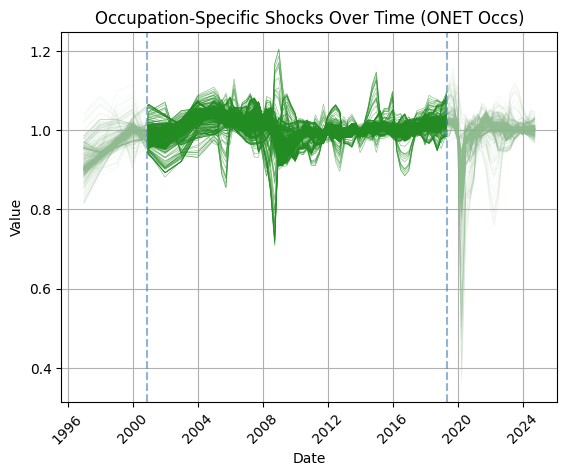

In [22]:
from scipy.optimize import minimize
from scipy.stats import norm

mod_data, net_temp, vacs, occ_ids, occ_shocks_dat = network_input_builder("full_omn")

# wage_comp = mod_data['wages']
wage_comp = pd.read_csv(path +"calibration_remote/dRC_Replication/data/ipums_variables_full_omn_w_exp.csv", delimiter = ",")
wage_comp = wage_comp[['acs_occ_code', 'median_weekly_earnings']]
wage_comp['median_annual_earnings'] = wage_comp['median_weekly_earnings'] * 52

wage_dist = pd.read_csv(path + "data/occ_macro_vars/OEWS/wage_distributions_full_omn.csv", compression='gzip',  delimiter=",", header = 0)

occ_ids = pd.read_csv("/Users/ebbamark/OneDrive - Nexus365/GenerateOccMobNets/data/occ_names_employment_asec_occ.csv", delimiter=",")[['Code', 'Label']]
occ_ids = occ_ids.rename(columns={"Label": "label"})
occ_ids['id'] = occ_ids.index.values

def fit_lognormal_all(p10, p25, p50, p75, p90):
    """Fit lognormal parameters (mu, sigma) to multiple percentiles."""
    quantiles = np.array([0.10, 0.25, 0.50, 0.75, 0.90])
    observed = np.log(np.array([p10, p25, p50, p75, p90]))  # log wages
    def loss(params):
        mu, sigma = params
        predicted = mu + sigma * norm.ppf(quantiles)
        return np.sum((predicted - observed) ** 2)

    # Initial guess
    init = [np.log(p50), 0.3]
    result = minimize(loss, init, bounds=[(None, None), (1e-6, None)])

    return result.x  # (mu, sigma)


wage_full = wage_comp.merge(wage_dist, left_on='acs_occ_code', right_on='acs_occ_code', how='inner')


def draw_samples_safe(row, n_draws):
    # calculate mu/sigma from percentiles
    mu_calc, sigma_calc = fit_lognormal_all(
        row['a_pct10'], row['a_pct25'], row['a_median'], row['a_pct75'], row['a_pct90']
    )

    # check once per session/cell run (do not save diagnostics to the output dataframe)

    assert(np.isclose(mu_calc, row['mu'], rtol=1e-3, atol=1e-6))
    assert(np.isclose(sigma_calc, row['sigma'], rtol=1e-3, atol=1e-6))

    # if not (mu_close and sigma_close):
    #     print(
    #         f"Occ {row['acs_occ_code']}: mu_calc={float(mu_calc):.6f} mu_row={float(row['mu']):.6f} "
    #         f"sigma_calc={float(sigma_calc):.6f} sigma_row={float(row['sigma']):.6f}"
    #     )
    # else:
    #     print(
    #         "passed"
    #         # f"Occ {row['acs_occ_code']}: mu and sigma close "
    #         # f"(mu_diff={float(mu_calc - row['mu']):.3e}, sigma_diff={float(sigma_calc - row['sigma']):.3e})"
    #     )

    # use the stored mu/sigma for sampling (keeps behavior)
    lognorm_draws = np.random.lognormal(row['mu'], row['sigma'], n_draws)

    median = float(row['a_median'])
    sd = 0.05 * median
    normal_draws = np.random.normal(median, sd, n_draws)
    normal_draws = np.clip(normal_draws, 0, None)

    old_median = float(row['median_weekly_earnings'] * 52)
    old_sd = 0.05 * old_median
    old_draws = np.random.normal(old_median, old_sd, n_draws)
    old_draws = np.clip(old_draws, 0, None)

    return pd.DataFrame({
        'occupation': row.get('acs_occ_code', 'unknown'),
        'occupation_name': (
            occ_ids.loc[occ_ids['Code'] == row.get('acs_occ_code', -1), 'label'].values[0]
            if not occ_ids.loc[occ_ids['Code'] == row.get('acs_occ_code', -1)].empty else 'unknown'
        ),
        'lognormal_draw': lognorm_draws,
        'normal_median_draw': normal_draws,
        'old_median_draw': old_draws
    })

samples = pd.concat(
    wage_full.apply(draw_samples_safe, axis=1, args=(1000,)).values,
    ignore_index=True
)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

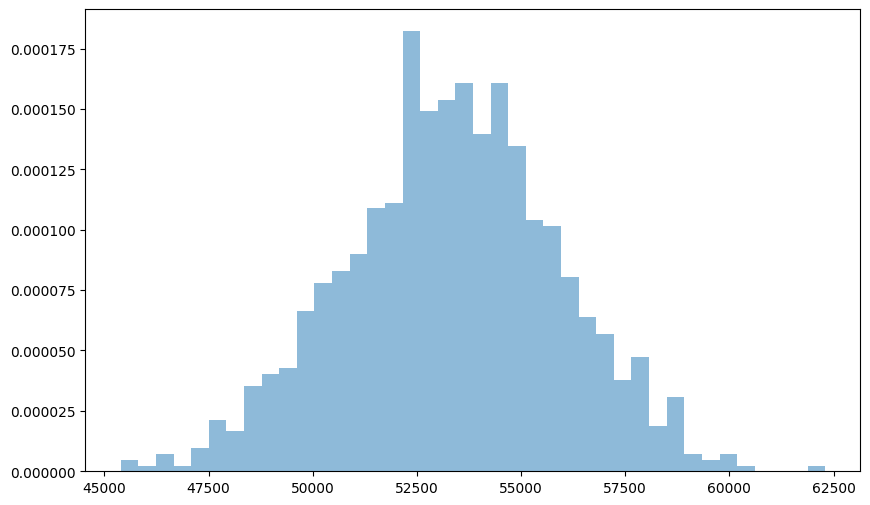

In [23]:
save = True
if save:
    base_path = os.path.expanduser("~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/")
    save_dir = os.path.join(base_path, "calibration_remote/output/plots_wage_distributions/")

# Loop over each occupation in your samples DataFrame
for occ_name in samples['occupation'].unique():
    subset = samples[samples['occupation'] == occ_name]

    # Get a readable name if available
    occ_label = subset['occupation_name'].iloc[0] if 'occupation_name' in subset.columns else ''
    safe_label = str(occ_label).replace('/', '_').replace(' ', '_')
    safe_occ = str(occ_name).replace('/', '_')

    plt.figure(figsize=(10,6))

    plt.hist(subset['normal_median_draw'], bins=40, alpha=0.5, density=True,
             label='Normal w. New Data (Median ±5%)')
    plt.hist(subset['old_median_draw'], bins=40, alpha=0.5, density=True,
             label='Normal w. Old Data (Median ±5%)')
    plt.hist(subset['lognormal_draw'], bins=40, alpha=0.5, density=True,
             label='Fitted Lognormal (New Data)')

    plt.suptitle("Wage Draw Comparison", fontsize=14)
    plt.title(f"Occupation: {occ_name} - {occ_label}", fontsize=10)
    plt.xlabel("Wage ($)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()

    # Save the figure
    if save:
        file_name = f"{safe_occ}_{safe_label}.png"
        plt.savefig(f'{save_dir}{file_name}', dpi=300)
        plt.close()  # close to free memory
    else:
        #plt.show()
        plt.close()

if save:
    print(f"Saved one plot per occupation to: {save_dir}")


NaNs/Infs detected for occupation 7440 (old_median_draw): 1000 of 1000 values removed.


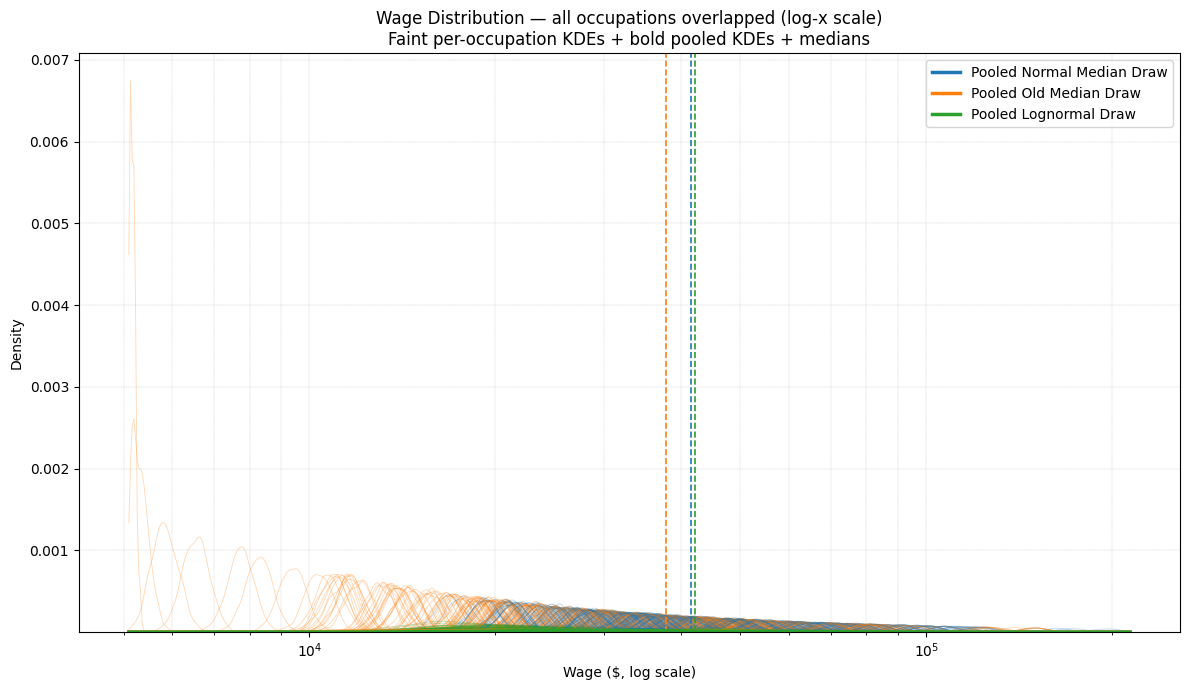

In [7]:
from scipy.stats import gaussian_kde
# choose colors for the three draw types

# color scheme
colors = {
    'normal_median_draw': '#1f77b4',     # blue
    'old_median_draw': '#ff7f0e',   # orange
    'lognormal_draw': '#2ca02c'   # green
}

def clean_array(a, occ_name=None, col_name=None):
    """Clean an array and print warnings if NAs or infs are found."""
    a = np.asarray(a, dtype=float)
    n_before = len(a)
    n_nonna = np.isfinite(a).sum()
    n_removed = n_before - n_nonna
    if n_removed > 0 and occ_name is not None and col_name is not None:
        print(f"NaNs/Infs detected for occupation {occ_name} ({col_name}): "
              f"{n_removed} of {n_before} values removed.")
    a = a[np.isfinite(a)]
    a = a[a > 0]  # remove zeros and negatives (for log scale)
    return a

# optionally limit number of occupations
occ_list = samples['occupation'].unique()
# occ_list = np.random.choice(occ_list, size=min(100, len(occ_list)), replace=False)

# pooled range
all_vals = np.concatenate([
    clean_array(samples['normal_median_draw']),
    clean_array(samples['old_median_draw']),
    clean_array(samples['lognormal_draw'])
])

xmin, xmax = np.percentile(all_vals, [0.5, 99.5])
xmin = max(xmin, 1e-6)
xs = np.exp(np.linspace(np.log(xmin/1.2), np.log(xmax*1.2), 600))

plt.figure(figsize=(12, 7))

alpha_per_occ = 0.3

# --- Per-occupation faint KDEs ---
for occ in occ_list:
    subset = samples[samples['occupation'] == occ]
    if len(subset) < 5:
        continue
    for col in ['normal_median_draw', 'old_median_draw', 'lognormal_draw']:
        vals = clean_array(subset[col].values, occ_name=occ, col_name=col)
        vals = vals[(vals >= xs.min()) & (vals <= xs.max())]
        if vals.size < 3:
            continue
        try:
            kde = gaussian_kde(np.log(vals))
            density = kde(np.log(xs)) / xs
            plt.plot(xs, density, color=colors[col], alpha=alpha_per_occ, linewidth=0.6)
        except Exception as e:
            print(f" KDE failed for occupation {occ} ({col}): {e}")
            continue

# --- Pooled KDEs (bold + filled) ---
for col in ['normal_median_draw', 'old_median_draw', 'lognormal_draw']:
    vals = clean_array(samples[col].values)
    vals = vals[(vals >= xs.min()) & (vals <= xs.max())]
    if vals.size < 3:
        continue
    kde = gaussian_kde(np.log(vals))
    density = kde(np.log(xs)) / xs
    plt.fill_between(xs, density, color=colors[col], alpha=0.7)
    plt.plot(xs, density, color=colors[col], linewidth=2.5, label=f'Pooled {col.replace("_", " ").title()}')
    # Median line
    med = np.median(vals)
    plt.axvline(med, color=colors[col], linestyle='--', linewidth=1.2)

plt.xscale('log')
plt.ylim(bottom=1e-6)
plt.xlabel('Wage ($, log scale)')
plt.ylabel('Density')
plt.title('Wage Distribution — all occupations overlapped (log-x scale)\n'
          'Faint per-occupation KDEs + bold pooled KDEs + medians')
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.3, alpha=0.7)
plt.tight_layout()

#out_file = os.path.join(save_dir, 'all_occupations_overlaid_wage_distributions_logx_with_warnings.png')
#plt.savefig(out_file, dpi=300)
plt.show()

# print(f"Saved improved plot to: {out_file}")


⚠️ NaNs/Infs detected for occupation 7440 (old_median_draw): 1000 of 1000 values removed.


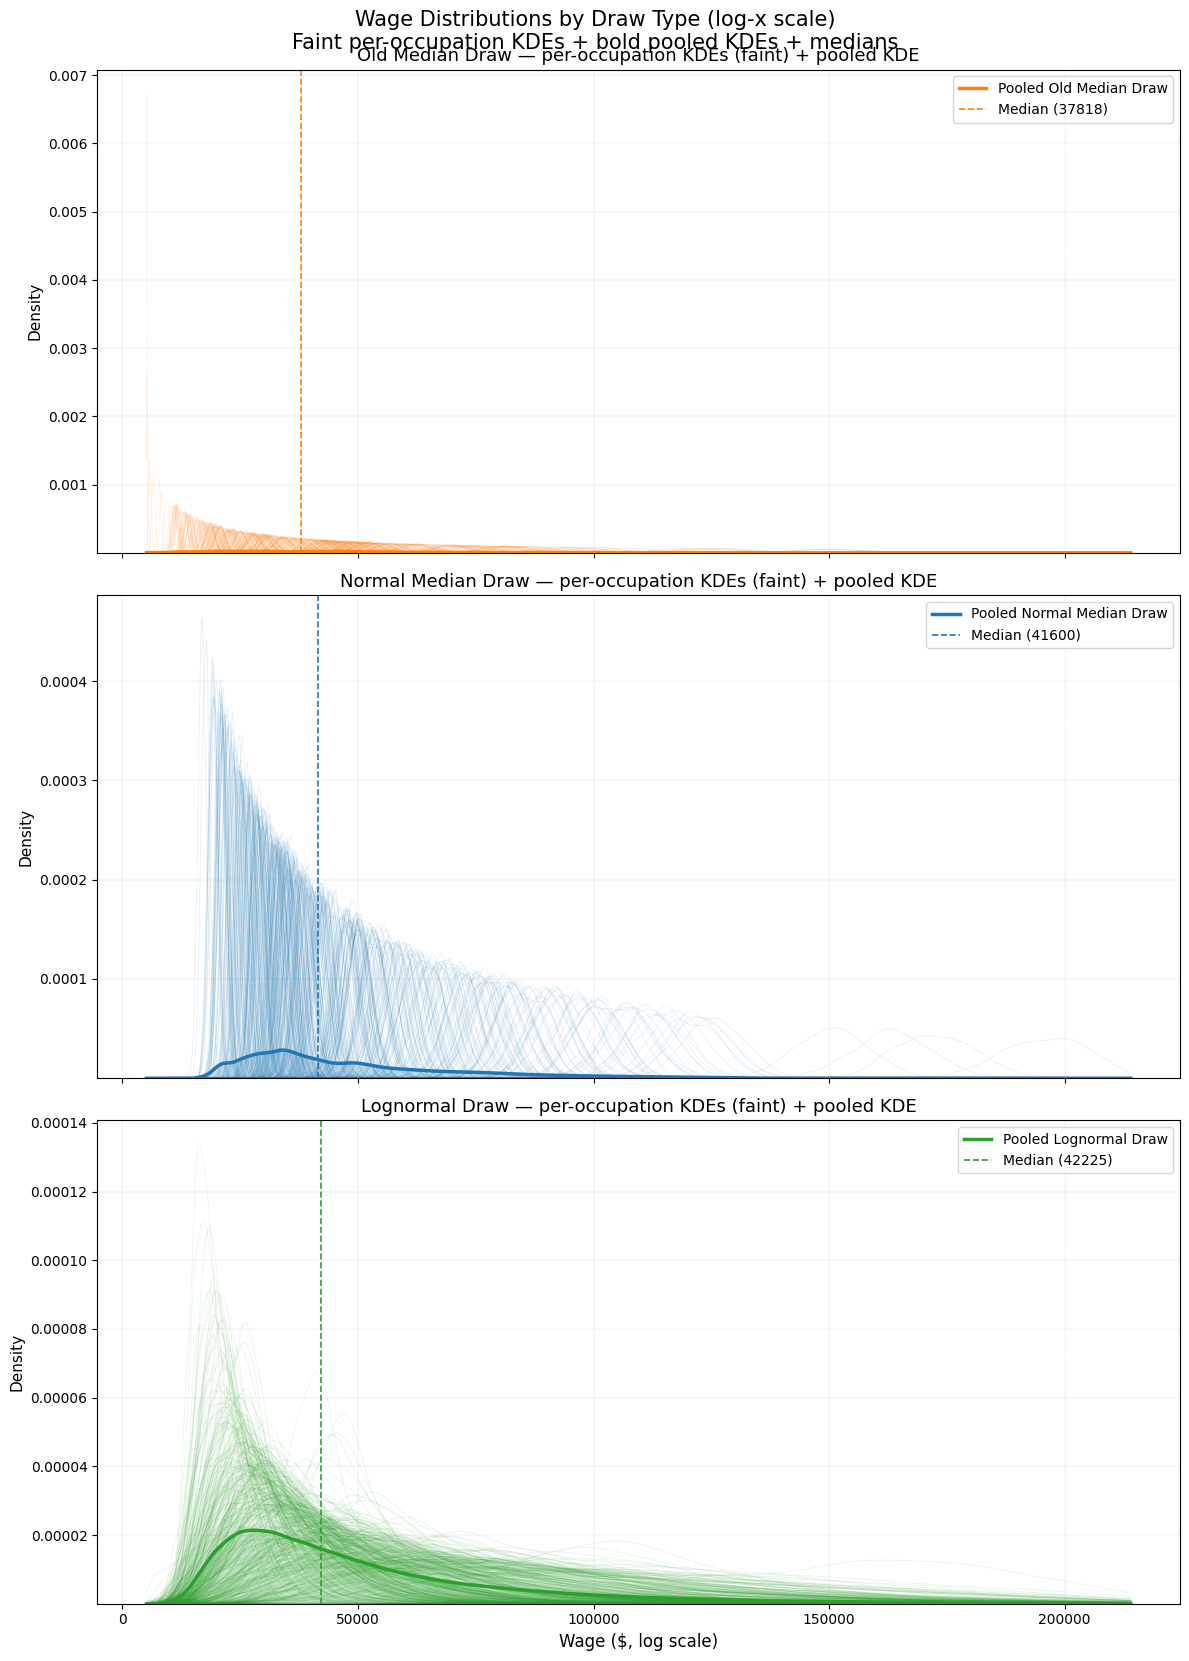

In [ ]:
# color scheme (one color used per plot, mapped for labels/file names)
colors = {
    'normal_median_draw': '#1f77b4',     # blue
    'old_median_draw': '#ff7f0e',   # orange
    'lognormal_draw': '#2ca02c'   # green
}

def clean_array(a, occ_name=None, col_name=None):
    """Clean an array and print warnings if NAs or infs are found."""
    a = np.asarray(a, dtype=float)
    n_before = len(a)
    n_nonna = np.isfinite(a).sum()
    n_removed = n_before - n_nonna
    if n_removed > 0 and occ_name is not None and col_name is not None:
        print(f"NaNs/Infs detected for occupation {occ_name} ({col_name}): "
              f"{n_removed} of {n_before} values removed.")
    a = a[np.isfinite(a)]
    a = a[a > 0]  # remove zeros and negatives (for log scale)
    return a

# optionally subsample to reduce overplotting
occ_list_all = samples['occupation'].unique()
# occ_list = np.random.choice(occ_list_all, size=min(150, len(occ_list_all)), replace=False)
occ_list = occ_list_all

# pooled plotting range (shared across all subplots)
all_vals = np.concatenate([
    clean_array(samples['normal_median_draw']),
    clean_array(samples['old_median_draw']),
    clean_array(samples['lognormal_draw'])
])
if all_vals.size == 0:
    raise RuntimeError("No positive finite draws found in samples.")

xmin, xmax = np.percentile(all_vals, [0.5, 99.5])
xmin = max(xmin, 1e-6)
xs = np.exp(np.linspace(np.log(xmin / 1.2), np.log(xmax * 1.2), 600))

# plotting parameters
alpha_per_occ = 0.1
pooled_fill_alpha = 0.18
pooled_linewidth = 2.5
per_occ_linewidth = 0.6
min_vals_for_kde = 3

# --- Create 3 vertically stacked subplots ---
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
draw_types = ['old_median_draw', 'normal_median_draw', 'lognormal_draw']

for ax, col in zip(axes, draw_types):
    color = colors[col]

    # per-occupation faint KDEs
    for occ in occ_list:
        subset = samples[samples['occupation'] == occ]
        if len(subset) < 5:
            continue
        vals = clean_array(subset[col].values, occ_name=occ, col_name=col)
        vals = vals[(vals >= xs.min()) & (vals <= xs.max())]
        if vals.size < min_vals_for_kde or np.nanstd(vals) == 0:
            continue
        try:
            kde = gaussian_kde(np.log(vals))
            density = kde(np.log(xs)) / xs
            ax.plot(xs, density, color=color, alpha=alpha_per_occ, linewidth=per_occ_linewidth)
        except Exception as e:
            print(f"⚠️ KDE failed for occupation {occ} ({col}): {e}")
            continue

    # pooled KDE (bold + filled)
    pooled_vals = clean_array(samples[col].values)
    pooled_vals = pooled_vals[(pooled_vals >= xs.min()) & (pooled_vals <= xs.max())]
    if pooled_vals.size >= min_vals_for_kde and np.nanstd(pooled_vals) > 0:
        try:
            kde = gaussian_kde(np.log(pooled_vals))
            density = kde(np.log(xs)) / xs
            ax.fill_between(xs, density, color=color, alpha=pooled_fill_alpha)
            ax.plot(xs, density, color=color, linewidth=pooled_linewidth,
                    label=f'Pooled {col.replace("_", " ").title()}')
            med = np.median(pooled_vals)
            ax.axvline(med, color=color, linestyle='--', linewidth=1.2, label=f'Median ({int(med)})')
        except Exception as e:
            print(f"⚠️ Pooled KDE failed for {col}: {e}")
    else:
        if pooled_vals.size > 0:
            med = np.median(pooled_vals)
            ax.axvline(med, color=color, linestyle='--', linewidth=1.2, label=f'Median ({int(med)})')
            print(f"⚠️ Not enough pooled values for KDE for {col}. Showing median only.")

    # cosmetics
    #ax.set_xscale('log')
    ax.set_ylim(bottom=1e-8)
    ax.grid(True, which='both', ls='--', lw=0.3, alpha=0.6)
    pretty_col = col.replace('_', ' ').title()
    ax.set_title(f'{pretty_col} — per-occupation KDEs (faint) + pooled KDE', fontsize=13)
    ax.legend()

# shared labels and layout
axes[-1].set_xlabel('Wage ($, log scale)', fontsize=12)
for ax in axes:
    ax.set_ylabel('Density', fontsize=11)
fig.suptitle('Wage Distributions by Draw Type (log-x scale)\nFaint per-occupation KDEs + bold pooled KDEs + medians',
             fontsize=15, y=0.92)
fig.tight_layout(rect=[0, 0, 1, 0.94])

# save one PNG
#out_file = os.path.join(save_dir, 'all_occupations_wage_distributions_stacked_logx.png')
#plt.savefig(out_file, dpi=300)
plt.show()

#print(f"\n Saved combined 3-in-1 plot to: {out_file}")

In [ ]:
from PIL import Image
base_path = os.path.expanduser("~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/")
save_dir = os.path.join(base_path, "calibration_remote/output/plots_wage_distributions/detailed_occs/")

# List your files (top-left, top-right, bottom-left, bottom-right)
file_names = [
    f"{save_dir}10_Chief_executives.png",
    f"{save_dir}360_Natural_sciences_managers.png",
    f"{save_dir}5510_Couriers_and_messengers.png",
    f"{save_dir}5400_Receptionists_and_information_clerks.png"
]

# Open all images
images = [Image.open(f) for f in file_names]

# --- Normalize image sizes ---
# Resize all to the same dimensions (use the smallest width/height to preserve quality)
widths, heights = zip(*(im.size for im in images))
target_width = min(widths)
target_height = min(heights)

images = [im.resize((target_width, target_height), Image.LANCZOS) for im in images]

# --- Create a blank canvas for 2x2 grid ---
cols, rows = 2, 2
grid_width = cols * target_width
grid_height = rows * target_height
combined = Image.new('RGB', (grid_width, grid_height), color=(255, 255, 255))

# --- Paste images in 2x2 layout ---
positions = [
    (0, 0),  # top-left
    (target_width, 0),  # top-right
    (0, target_height),  # bottom-left
    (target_width, target_height)  # bottom-right
]

for pos, im in zip(positions, images):
    combined.paste(im, pos)

# --- Save final combined image ---
output_file = os.path.join(save_dir, 'combined_sample_wage_distributions_2x2.png')
combined.save(output_file, dpi=(300, 300))
print(f"Saved combined 2×2 grid PNG: {output_file}")

✅ Saved combined 2×2 grid PNG: /Users/ebbamark/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/output/plots_wage_distributions/combined_sample_wage_distributions_2x2.png


In [ ]:
ipums_input = pd.read_csv(path + "calibration_remote/dRC_Replication/data/acs_onet_2010_ipums_vars_w_exp.csv", delimiter=",")

wage_comp = ipums_input[['acs_occ_code', 'median_weekly_earnings']]
wage_comp['median_annual_earnings'] = wage_comp['median_weekly_earnings'] * 52
wage_dist = pd.read_csv("~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/data/occ_macro_vars/OEWS/wage_distributions_onet.csv", compression='gzip',  delimiter=",", header = 0)
wage_full = wage_comp.merge(wage_dist, left_on='acs_occ_code', right_on='acs_occ_code', how='inner')

# the z-scores corresponding to each quantile
qs = np.array([0.10, 0.25, 0.50, 0.75, 0.90])
zs = norm.ppf(qs)   # array([-1.28155157, -0.67448975,  0.,  0.67448975,  1.28155157])

# Apply to whole DataFrame (vectorizing via .apply is fine for 528 rows)
mu_sigma = wage_full.apply(fit_mu_sigma_from_row, axis=1, result_type='expand')
mu_sigma.columns = ['mu', 'sigma']
wage_full = pd.concat([wage_full, mu_sigma], axis=1)


/var/folders/34/6r0xdq916zn1qsvypkxnsqkw0000gr/T/ipykernel_5235/1203744718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wage_comp['median_annual_earnings'] = wage_comp['median_weekly_earnings'] * 52
